## IMPORT DATASET 

In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("upload_data").getOrCreate()


df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)



In [2]:

df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Spark session start
spark = SparkSession.builder.appName("AddHeaderToDataFrame").getOrCreate()

columns = ["number", "id", "date", "query", "username", "text"]



# Header row
header = ("number", "id", "date", "query", "username", "text")

# Adding header row
df = df.toDF(*header)


df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|        id|                date|   query|       username|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_

In [4]:

df.printSchema()



root
 |-- number: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
drop_cols= ("id","query","username")
df = df.drop(*drop_cols)

In [6]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  3 columns in the dataset.


In [7]:
# Missing values check

from pyspark.sql import functions as func

df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,number,date,text
0,0,0,0


In [8]:
# Duplicates check

df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


In [9]:
#  Column types

df.dtypes


[('number', 'int'), ('date', 'string'), ('text', 'string')]

In [10]:
df.printSchema()


root
 |-- number: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)



In [11]:
df.show(5, truncate = False)

+------+----------------------------+--------------------------------------------------------------------------------------------+
|number|date                        |text                                                                                        |
+------+----------------------------+--------------------------------------------------------------------------------------------+
|146   |Mon Apr 06 22:28:26 PDT 2009|my nokia 1110 died..                                                                        |
|851   |Mon Apr 06 23:18:02 PDT 2009|@stewiebrittany no  i dont even know how to ride it                                         |
|1436  |Tue Apr 07 00:01:00 PDT 2009|@CyFyre no   finished two years then had twinzzzzzzzzzzz                                    |
|1508  |Tue Apr 07 00:05:37 PDT 2009|Oh dear, all the pups died 1 by 1 last night, perhaps it was because Princess rejected them |
|1756  |Tue Apr 07 00:23:59 PDT 2009|Somewhere in the world right now the sun is sh

## CLEAN TEXT

In [12]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [13]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# TOKENIZATION

In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
from pyspark.sql.types import StringType,FloatType

%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.62 µs


In [17]:
df.show()


+------+--------------------+--------------------+--------------------+
|number|                date|                text|        text_cleaned|
+------+--------------------+--------------------+--------------------+
|   146|Mon Apr 06 22:28:...|my nokia 1110 die...|     nokia 1110 died|
|   851|Mon Apr 06 23:18:...|@stewiebrittany n...| dont even know ride|
|  1436|Tue Apr 07 00:01:...|@CyFyre no   fini...|finished two year...|
|  1508|Tue Apr 07 00:05:...|Oh dear, all the ...|oh dear pups died...|
|  1756|Tue Apr 07 00:23:...|Somewhere in the ...|somewhere world r...|
|  1760|Tue Apr 07 00:24:...|Goodnight everyon...|goodnight everyon...|
|  1777|Tue Apr 07 00:25:...|oh em gee. this i...|oh em gee love wa...|
|  1817|Tue Apr 07 00:29:...|trying to write d...|trying write dsse...|
|  2015|Tue Apr 07 00:45:...| there is no way ...|way go school tod...|
|  2063|Tue Apr 07 00:48:...|@Cuckolds I'm bei...|set except watch ...|
|  2239|Tue Apr 07 01:02:...|Borning - thats m...|borning thats 

In [18]:
df = df.drop("text")


In [19]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

window_spec = Window.orderBy("date")

df = df.withColumn("row_number", F.row_number().over(window_spec))

df.show()


2023-11-14 22:45:21,333 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+
|number|                date|        text_cleaned|row_number|
+------+--------------------+--------------------+----------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|
|  8580|Fri Apr 17 20:30:...|aww r cutest thin...|         6|
|  8582|Fri Apr 17 20:30:...|boyfriend going t...|         7|
|  8581|Fri Apr 17 20:30:...|sweet josh work t...|         8|
|  8585|Fri Apr 17 20:30:...|sorry loss honey ...|         9|
|  8584|Fri Apr 17 20:30:...|losing followers lol|        10|
|  8586|Fri Apr 17 20:30:...|               tired|        11|
|  8583|Fri Apr 17 20:30:...|sim see tonight e...|        12|
|  8588|Fri Apr 17 20:30:...|misses updating c...|        13|
|  8587|

## SENTIMENT ANALYSIS

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from textblob import TextBlob


#  UDF (User-Defined Function) 
schema = StructType([StructField("polarity", FloatType(), True), StructField("subjectivity", FloatType(), True)])

def calc_sentiment_udf(txt):
    blob = TextBlob(txt)
    return (blob.sentiment.polarity, blob.sentiment.subjectivity)

sentiment_udf = udf(calc_sentiment_udf, schema)

df = df.withColumn("sentiment", sentiment_udf(df["text_cleaned"]))

df = df.withColumn("polarity", df["sentiment.polarity"])
df = df.withColumn("subjectivity", df["sentiment.subjectivity"])

df.sample(withReplacement=False, fraction=0.1).show()


2023-11-14 22:45:59,890 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+----------+------------+
|number|                date|        text_cleaned|row_number|           sentiment|  polarity|subjectivity|
+------+--------------------+--------------------+----------+--------------------+----------+------------+
|  8582|Fri Apr 17 20:30:...|boyfriend going t...|         7|         {-0.1, 0.7}|      -0.1|         0.7|
|  8594|Fri Apr 17 20:31:...|colorado beautifu...|        19|        {0.525, 0.6}|     0.525|         0.6|
|  8616|Fri Apr 17 20:31:...|dear amp get act ...|        42|   {0.16666667, 0.5}|0.16666667|         0.5|
|  8627|Fri Apr 17 20:31:...|sms tweets still ...|        52|         {-0.5, 0.3}|      -0.5|         0.3|
|  8634|Fri Apr 17 20:32:...|cant believe boys...|        62|          {0.0, 0.1}|       0.0|         0.1|
|812112|Fri Apr 17 20:32:...|jasmine tea new i...|        76|{0.24060605, 0.35...|0.24060605|  0.35090908|
|812108|Fri Apr 17 20:32:...|loving g

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

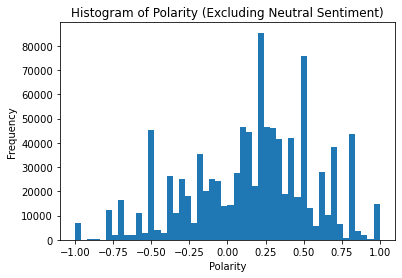

In [22]:
processed_data = df.filter(df["polarity"] != 0.0).select("polarity").toPandas()

plt.hist(processed_data["polarity"], bins=50)
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Histogram of Polarity (Excluding Neutral Sentiment)")
plt.show()

In [23]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


from pyspark.sql.functions import to_timestamp

timestamp = to_timestamp("Mon Nov 05 20:40:00 2023 PST", "EEE MMM dd HH:mm:ss yyyy Z")


In [24]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType



# Convert the date column to a Timestamp type.
df = df.withColumn("new_date", F.to_timestamp(df["date"], "EEE MMM dd HH:mm:ss z yyyy"))

# Cast the new_date column to a TimestampType.
df = df.withColumn("new_date", F.col("new_date").cast(TimestampType()))

# Display the DataFrame.
df.show()


2023-11-14 22:47:54,971 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|number|                date|        text_cleaned|row_number|           sentiment|   polarity|subjectivity|           new_date|
+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|{-0.24583334, 0.5...|-0.24583334|   0.5708333|2009-04-18 04:30:31|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|          {0.0, 0.0}|        0.0|         0.0|2009-04-18 04:30:34|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|         {-0.3, 0.4}|       -0.3|         0.4|2009-04-18 04:30:38|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|{-0.5515873, 0.84...| -0.5515873|   0.8452381|2009-04-18 04:30:39|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|{-0.125, 0.41666666}|     -0.125|  0.416666

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

# SparkSession oluştur
spark = SparkSession.builder.appName("TwitterDataProcessing").getOrCreate()


# 'new_date' sütununu tarih formatına çevir
df = df.withColumn("time", col("new_date").cast(TimestampType()))

# Gereksiz sütunları çıkar
df = df.select("number", "time", "polarity")

# 'new_date' sütununu çıkar
df = df.drop("new_date")

# 'time' sütununa göre sırala
df = df.orderBy("time")

# Sonuçları göster
df.show(truncate=False)


+------+-------------------+-----------+
|number|time               |polarity   |
+------+-------------------+-----------+
|0     |2009-04-07 06:19:45|0.2        |
|1     |2009-04-07 06:19:49|0.0        |
|2     |2009-04-07 06:19:53|0.5        |
|4     |2009-04-07 06:19:57|-0.625     |
|3     |2009-04-07 06:19:57|0.2        |
|5     |2009-04-07 06:20:00|0.2        |
|7     |2009-04-07 06:20:03|0.34166667 |
|6     |2009-04-07 06:20:03|0.0        |
|8     |2009-04-07 06:20:05|0.0        |
|9     |2009-04-07 06:20:09|0.0        |
|10    |2009-04-07 06:20:16|-0.21428572|
|11    |2009-04-07 06:20:17|0.0        |
|13    |2009-04-07 06:20:19|0.0        |
|12    |2009-04-07 06:20:19|0.0        |
|14    |2009-04-07 06:20:20|0.225      |
|15    |2009-04-07 06:20:20|0.0        |
|16    |2009-04-07 06:20:22|0.0        |
|17    |2009-04-07 06:20:25|0.0        |
|18    |2009-04-07 06:20:31|0.5        |
|19    |2009-04-07 06:20:34|0.0        |
+------+-------------------+-----------+
only showing top

## GENERAL STATS

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Spark session oluşturun
spark = SparkSession.builder.appName("PolarityStatistics").getOrCreate()


# "polarity" sütununun istatistiklerini alın
polarity_stats = df.select("polarity").describe()

# İstatistikleri göster
polarity_stats.show()


+-------+-------------------+
|summary|           polarity|
+-------+-------------------+
|  count|            1600000|
|   mean|0.09760413173740876|
| stddev|0.33521470805192083|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



## WEEKLY STATS

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, weekofyear, max, min, mean, stddev

# Spark session oluşturun
spark = SparkSession.builder.appName("WeeklyPolarityStatistics").getOrCreate()


# "time" sütununu tarih ve hafta numarasına çevirin
df = df.withColumn("time", col("time").cast("timestamp"))
df = df.withColumn("week", weekofyear("time"))

# Haftalık istatistikleri alın
weekly_stats = df.groupBy("week").agg(
    mean("polarity").alias("avg_polarity"),
    stddev("polarity").alias("stddev_polarity"),
    min("polarity").alias("min_polarity"),
    max("polarity").alias("max_polarity")
)

# İstatistikleri göster
weekly_stats.show()


+----+--------------------+-------------------+------------+------------+
|week|        avg_polarity|    stddev_polarity|min_polarity|max_polarity|
+----+--------------------+-------------------+------------+------------+
|  26|-0.01394785479974...|0.32733840598699987|        -1.0|         1.0|
|  22| 0.12566666412672822|0.33263216488193664|        -1.0|         1.0|
|  16|  0.1198705260658071|0.33030722741464014|        -1.0|         1.0|
|  20| 0.12063526645990055| 0.3333513572334279|        -1.0|         1.0|
|  19| 0.13571751746660493|0.34916671097718927|        -1.0|         1.0|
|  15| 0.10502953406290622| 0.3334875376553313|        -1.0|         1.0|
|  17| 0.11721694645543472|0.33144181227495584|        -1.0|         1.0|
|  23| 0.11730814922956001|0.33192869293531535|        -1.0|         1.0|
|  25| 0.04095277050689163| 0.3323633410348466|        -1.0|         1.0|
|  24| 0.11503489054103769| 0.3354607628668065|        -1.0|         1.0|
|  21|  0.1277597873514982| 0.33274332

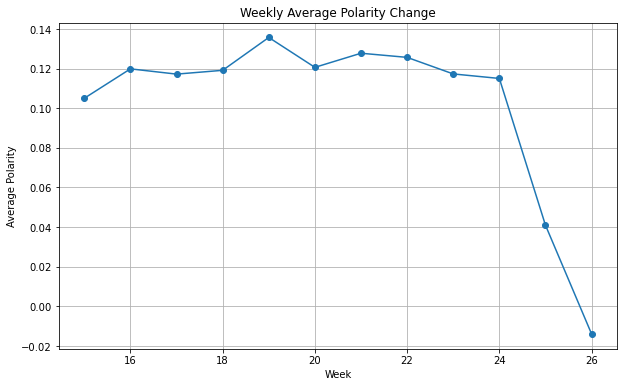

In [28]:
import matplotlib.pyplot as plt

# Spark DataFrame'i week sütununa göre sırala
sorted_weekly_stats = weekly_stats.orderBy("week")

# Pandas DataFrame'e çevirme
pandas_weekly_stats = sorted_weekly_stats.toPandas()

# Grafiği çizme
plt.figure(figsize=(10, 6))
plt.plot(pandas_weekly_stats['week'], pandas_weekly_stats['avg_polarity'], marker='o', linestyle='-')
plt.title('Weekly Average Polarity Change')
plt.xlabel('Week')
plt.ylabel('Average Polarity')
plt.grid(True)
plt.show()


## FORECAST

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyspark.sql import SparkSession


# PySpark DataFrame'ini Pandas DataFrame'ine dönüştür
df_pandas = df.toPandas()

# Regresyon modelini oluştur
X = sm.add_constant(df_pandas['number'])
y = df_pandas['polarity']
model = sm.OLS(y, X).fit()

# Gelecek 1 haftalık tahminleri yap
future_numbers = np.arange(df_pandas['number'].max() + 1, df_pandas['number'].max() + 8)
future_X = sm.add_constant(future_numbers)

future_predictions = model.predict(future_X)
future_dates = pd.date_range(start=df_pandas['time'].max(), periods=7, freq='D')
future_df = pd.DataFrame({'time': future_dates, 'number': future_numbers, 'predicted_polarity': future_predictions})

# Tahmin sonuçlarını göster
print(future_df)


                 time   number  predicted_polarity
0 2009-06-25 17:28:31  1600000            0.254431
1 2009-06-26 17:28:31  1600001            0.254431
2 2009-06-27 17:28:31  1600002            0.254431
3 2009-06-28 17:28:31  1600003            0.254432
4 2009-06-29 17:28:31  1600004            0.254432
5 2009-06-30 17:28:31  1600005            0.254432
6 2009-07-01 17:28:31  1600006            0.254432


In [33]:
from sklearn.metrics import r2_score

# Gerçek değerler
actual_values = df_pandas['polarity']

# Tahmin edilen değerler
predicted_values = model.predict(X)

# R-kare skoru hesapla
r2 = r2_score(actual_values, predicted_values)
print(f'R-squared Score: {r2}')


R-squared Score: 0.07295802573134502


/tmp/ipykernel_5553/3782944843.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
/home/hduser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


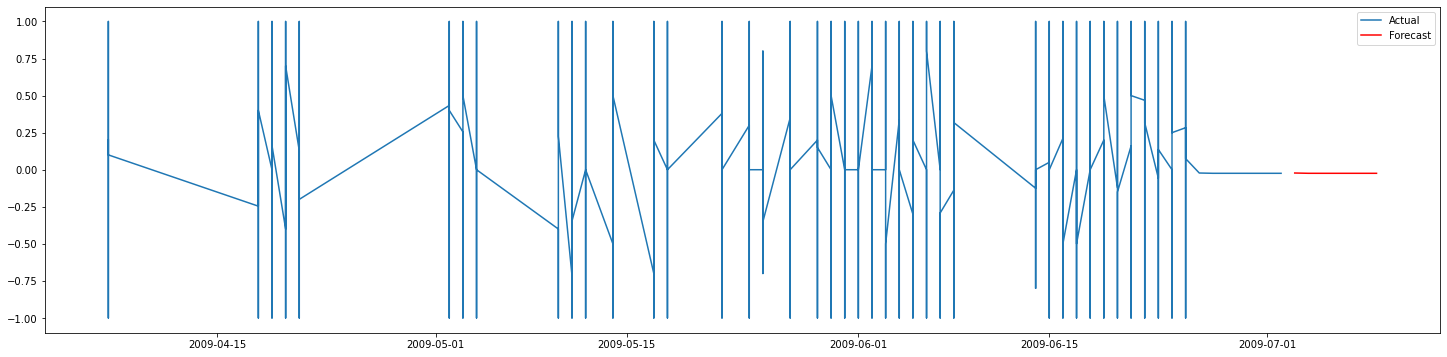

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

# PySpark Session oluştur
spark = SparkSession.builder.appName("ARIMA_Example").getOrCreate()

# 'time' sütununu tarih formatına dönüştür
df_spark = df.withColumn("time", col("time").cast("date"))

# Haftalık gruplama ve ortalama alma işlemleri
window_spec = Window.orderBy("time").rowsBetween(-float('inf'), 0)
df_spark = df_spark.withColumn("weekly_avg_polarity", col("polarity"))
df_spark = df_spark.withColumn("weekly_avg_polarity", col("weekly_avg_polarity").cast("double"))

# ARIMA modelini oluştur
model = ARIMA(df_spark.select("weekly_avg_polarity").toPandas(), order=(1, 1, 1))  # (p, d, q) değerlerini istediğiniz gibi ayarlayabilirsiniz
results = model.fit()

# Gelecek 7 gün için tahmin yap
forecast_steps = 7
forecast = results.get_forecast(steps=forecast_steps)

# Tahmin edilen değerler ve güven aralıklarını al
forecast_values = forecast.predicted_mean

# Önceki verileri ve tahminleri birleştir
df_forecast = df_spark.toPandas()
df_forecast = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
                                                "weekly_avg_polarity": forecast_values}))

# Tahmin edilen değerleri ve güven aralıklarını görselleştir
plt.figure(figsize=(25, 6)) 
plt.plot(df_forecast['time'], df_forecast['weekly_avg_polarity'], label='Actual')
plt.plot(pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast_values, color='red', label='Forecast')
plt.legend()
plt.show()


In [ ]:
# ARIMA modelini oluştur
model = ARIMA(df_spark.select("weekly_avg_polarity").toPandas(), order=(1, 1, 1))  # Başlangıç için (1, 1, 1)
results = model.fit()

# AIC değerini yazdırarak modelin uygunluğunu değerlendir
print("AIC:", results.aic)

# Başka bir kombinasyon deneyebilir ve en iyi sonucu elde edene kadar tekrarlayabilirsiniz
model = ARIMA(df_spark.select("weekly_avg_polarity").toPandas(), order=(12, 1, 5))  # Diğer kombinasyonlar için p, d, q değerlerini belirleyin
results = model.fit()
print("AIC:", results.aic)


AIC: 1006980.7207229253


## INTERACTIVE DASHBOARD

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import plotly.express as px
import dash
from dash import dcc, html

# SparkSession oluştur
spark = SparkSession.builder.appName("TwitterDataProcessing").getOrCreate()

# 'time' sütununu Timestamp türüne dönüştür
df = df.withColumn("time", col("time").cast(TimestampType()))

# Polarity değeri 0 olan satırları filtrele
df0 = df.filter(col("polarity") != 0)

# Günlük ortalamaları hesapla
df0 = df.withColumn("date", to_date("time"))
windowSpec = Window.partitionBy("date")

# Plotly Express kullanarak çizgi grafiği oluştur
fig = px.line(df0.toPandas(), x="date", y="polarity", title="Date X Polarity", line_shape="linear", color_discrete_sequence=['blue'])

# Dash uygulamasını başlat
app = dash.Dash(__name__)

# Dashboard layout
app.layout = html.Div(children=[
    dcc.Graph(id='line-chart', figure=fig)
])

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)


In [29]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "UTC")


+-------+------+
|   week| count|
+-------+------+
|2009-15| 20671|
|2009-16| 17154|
|2009-17| 62200|
|2009-18| 31096|
|2009-19| 54868|
|2009-20| 63480|
|2009-21|126975|
|2009-22|176668|
|2009-23|483516|
|2009-24|130459|
|2009-25|347232|
|2009-26| 85681|
+-------+------+



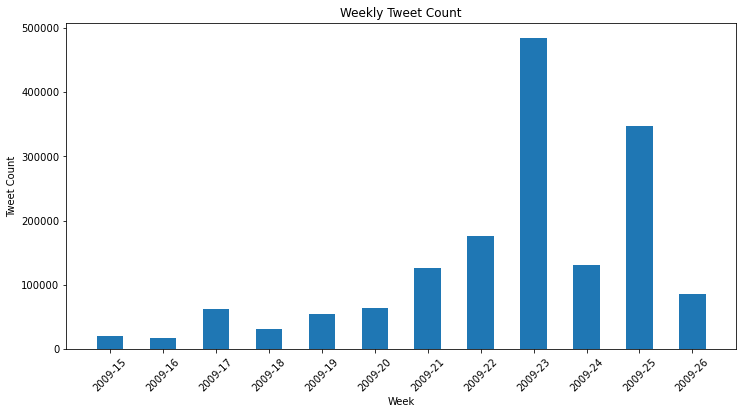

In [30]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format

# 1-Week Analysis
weekly_data = df.groupBy(date_format("time", "yyyy-ww")).count()
weekly_data = weekly_data.withColumnRenamed("date_format(time, yyyy-ww)", "week")
weekly_data = weekly_data.orderBy("week", ascending=True)
weekly_data.show()

# Get the result and visualize it
weekly_data_pd = weekly_data.toPandas()

# Plot for 1-Week Time Series
plt.figure(figsize=(12, 6))
plt.bar(weekly_data_pd["week"], weekly_data_pd["count"], width=0.5)
plt.title("Weekly Tweet Count")
plt.xlabel("Week")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()


#  CALISAN KISIM

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window
from pyspark.sql.window import Window

# Spark oturumu oluştur
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Tarih sütununu zaman damgasına dönüştür

df = df.withColumn("new_date", col("new_date").cast("timestamp"))

# 1 haftalık zaman serisi
weekly_series = df.groupBy(window("new_date", "1 week")).count()
weekly_series.show(truncate=False)

# 1 aylık zaman serisi (30 gün olarak hesaplanır)
monthly_series = df.groupBy(window("new_date", "30 days")).count()
monthly_series.show(truncate=False)

# 3 aylık zaman serisi (90 gün olarak hesaplanır)
quarterly_series = df.groupBy(window("new_date", "90 days")).count()
quarterly_series.show(truncate=False)

# Spark oturumunu kapat
spark.stop()


import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

from pyspark.sql import SparkSession

# SparkSession oluştur
spark = SparkSession.builder.appName("example").getOrCreate()


# Spark DataFrame'ini Pandas DataFrame'e dönüştür
df_pandas = df.toPandas()

# Dash uygulamasını oluştur
app = dash.Dash(__name__)

# Dashboard düzenini oluştur
app.layout = html.Div(children=[
    html.H1(children='Sentiment Analysis Dashboard'),

    dcc.Graph(
        id='sentiment-graph',
        figure=px.line(df_pandas, x='new_date', y='polarity', title='Polarity Change Over Time')
    )
])

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)
